In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
from InputSimulator import make_input, make_pattern_presentation_array, copy_and_paste_jittered_pattern
from InputSimulator import triple_input_runtime, remove_close_spikes, add_noise

In [2]:
tripling = True

runduration = 450 # [second]
dt = 0.001 # [second]
number_neurons = 2000

T = len(np.arange(dt, runduration, dt))

max_time_wo_spike = 0.05 # [second]
min_rate, max_rate = 0 , 90
max_change_speed = max_rate / max_time_wo_spike # 90/0.05 = 1800 (max_S in paper)
patternlength = 0.05 # [second]
pattern_freq = 0.25


max_rate_add = 10
min_rate_add = 10
max_time_wo_spike_add = 1000
max_change_speed_add = 0

number_pat = 1000  # number of neurons that take part in the pattern presentation
spike_del = 0.01
jitter_sd = 1

## Generating Input

In [3]:
indices, times = make_input(min_rate, max_rate, max_time_wo_spike, max_change_speed, runduration, number_neurons, dt)
position_copypaste = make_pattern_presentation_array(runduration, patternlength, pattern_freq)

In [4]:
len(times), max(times)

(16218682, 149.9989864437702)

In [5]:
def plot_input(times, indices, times_pattern=None, indices_pattern=None):
    sampletimes = times[(times < 0.6) & (indices < 100)]
    sampleindices = indices[(times < 0.6) & (indices < 100)]
    
    intervals = np.arange(0, 0.61, 0.05)
    colors = ['#c6dbef', '#9ecae1', '#6baed6', '#4292c6', '#2171b5', '#08519c']
    num_colors_needed = len(intervals) - 1
    num_colors_available = len(colors)
    colors = [colors[i % num_colors_available] for i in range(num_colors_needed)]
    for i in range(len(intervals) - 1):
        plt.axvline(intervals[i+1])
        plt.axvspan(intervals[i], intervals[i + 1], facecolor=colors[i], alpha=0.7)
    plt.plot(sampletimes, sampleindices, '.k', alpha=0.6)
    if times_pattern is not None and indices_pattern is not None:
        sampletimespattern = times_pattern[(times_pattern < 0.6) & (indices_pattern < 100)]
        sampleindicespattern = indices_pattern[(times_pattern < 0.6) & (indices_pattern < 100)]
        plt.plot(sampletimespattern, sampleindicespattern, '.r', alpha=0.6)
    plt.show()

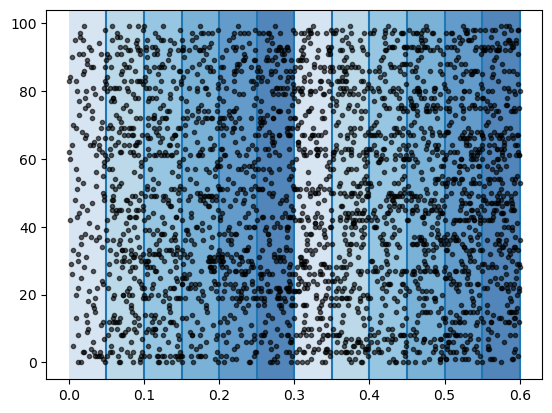

In [6]:
plot_input(times, indices)

In [7]:
indices, times, (indices_pattern, times_pattern) = copy_and_paste_jittered_pattern(times, indices, position_copypaste, patternlength, jitter_sd, spike_del,number_pat)
indices_add, times_add = make_input(min_rate_add, max_rate_add, max_time_wo_spike_add,
                                max_change_speed_add, runduration, number_neurons, dt)
times, indices = add_noise(times, indices, times_add, indices_add)
if tripling and runduration > 300:
        times, indices = triple_input_runtime(times, indices)
        position_copypaste = np.concatenate((position_copypaste, position_copypaste, position_copypaste))
times, indices = remove_close_spikes(times, indices, dt)
indices = indices.astype(int)

# patneurons = range(0, number_pat)
# nonpatneurons = range(number_pat, number_neurons)

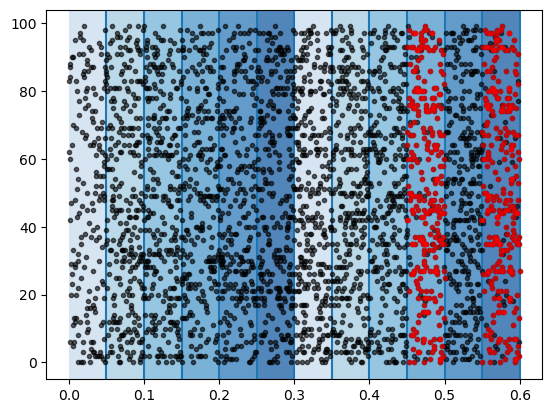

In [8]:
plot_input(times, indices, times_pattern, indices_pattern)

In [9]:
def get_interval_indices():
    """ This function return the indices in wich times array would change from a time interval to the nex
    for example if we have index 26 it means, times[25] = 0.000990 and times[26] = 0.00101
    """
    interval_indices = []
    for t in np.arange(dt,runduration+0.001,dt):
        ind = np.searchsorted(times, t)
        interval_indices.append(int(ind))
    # interval_indices = np.array(interval_indices).astype(int)
    interval_indices = tuple(interval_indices)
    return interval_indices

In [26]:
print(np.searchsorted(times, 0.001))
interval_indices = get_interval_indices()
print(times[interval_indices[0]-1: interval_indices[0]+1], 'ms')

55
[0.00099552 0.00100109] ms


In [11]:
def calc_min_diff_two_consequent_spikes():
    min_diff_two_consequent_spikes = 100
    index = -1
    for i in range(number_neurons):
        index_i_spikes = np.where(indices == i)[0]
        diffs = np.diff(times[index_i_spikes]).min()
        if min_diff_two_consequent_spikes > diffs:
            min_diff_two_consequent_spikes = diffs
            index = i
        if (i-1) % 200 == 0:
            print(f'{i-1} is done.')
    return index, min_diff_two_consequent_spikes

In [13]:
# index, min_diff_two_consequent_spikes = calc_min_diff_two_consequent_spikes()
# print(index, min_diff_two_consequent_spikes)

0 is done.
200 is done.
400 is done.
600 is done.
800 is done.
1000 is done.
1200 is done.
1400 is done.
1600 is done.
1800 is done.
1850 0.0010000013181965528


In [12]:
#             N * runduration
len(times),  (2000 * 450000)

(54672405, 900000000)

In [55]:
A_pre = 0.005
tau_pre = 0.020
tau_post = 0.020
B = 1.05
A_post = - A_pre * tau_post / tau_pre * B
tref = 0.001 # [second]

gE = 0 # for postsynapse
tau_E = 0.005 # 5 ms
g_bar_max = 0.05 
g_bar_i = np.ones(number_neurons) * 0.2 * g_bar_max # weight of synapse

P = np.zeros((number_neurons))
# last_spike_time_Pi = np.zeros((number_neurons)) # do I need this?!
M = 0


V = 0 # [mV]
V_thresh = - 0.054 # [mV]
V_rest = -0.070
V_reset = -0.060
tau_m = 0.020
E_E = 0

refractory_end_time = - 1.0


In [21]:
t = 449.999
print(int(t / 0.001)) # to get the interval number from spike time!
print(interval_indices[:5])

449999
(55, 128, 194, 252, 301)


In [31]:
# end of time interval 
#   - update M 
#   - update P_25
#   - update gE (total)
#   - update V
#   


interval_indices[0], times[54:56]


(55, array([0.00099552, 0.00100109]))

In [54]:
tref = 0.001
tref / dt
times[1000:1005]
times[1000] / dt

vtest = 2
vthrestest = 1
ref_end_time = -0.0004

for t in times[1000:1002]:
    if t < ref_end_time:
        print(f'for time {t} doing refractory')
        vtest = 0.5
        continue
    
    print('not doing this part anymore!')
    # t = 0.0160096
    if vtest > vthrestest:
        print(f'spike at {t} - refractory for 1ms')
        # refractory = True
        ref_end_time = t + tref 
        vtest = 0.5

    



not doing this part anymore!
spike at 0.016009692767848353 - refractory for 1ms
for time 0.016028379535686303 doing refractory


In [58]:
# counter = 0
rec_spikes = []
for i,t in enumerate(times):
    # print(f'{counter}. spike time {t:.7f}')
    # print(f'neuron index {indices[i]}')
    # print('***************')
    neuron_index = indices[i]
    
    if t < refractory_end_time:
        V = V_reset
        continue

    # on_pre for a specific neuron
    gE += g_bar_i[neuron_index]
    P[neuron_index] += A_pre
    g_bar_i[neuron_index] = np.clip(g_bar_i[neuron_index]+ M * g_bar_max, 0, g_bar_max)

    # on post
    if V > V_thresh:
        rec_spikes.append(t)
        V = V_reset
        M += A_post # A_post < 0
        g_bar_i[neuron_index] = np.clip(g_bar_i[neuron_index]+ P[neuron_index] * g_bar_max, 0, g_bar_max)
        # tr = tref / dt # refractory time / dt
        refractory_end_time = t + tref

    # end of time interval
    if i in interval_indices:
        M = M - dt/tau_post * M
        P = P - dt/tau_pre * P
        gE = gE - dt/tau_E * gE
        V = V + dt/tau_m * (V_rest - V + gE * (E_E - V))

    # if counter == 4:
    #     break
    # counter += 1

In [ ]:
tau_pos = 
A_pos = 
tau_neg = 
A_neg = 
refract = 0.001

V = np.zeros()

In [ ]:
for t in times:
    if tr> 0:
        

In [ ]:
def plot_input(times, indices, tstart, tend, times_pattern=None, indices_pattern=None,):
    sampletimes = times[(times < tend) & (times > tstart) & (indices < 100)]
    sampleindices = indices[(times < tend) & (times > tstart) & (indices < 100)]
    
    intervals = np.arange(0, 0.61, 0.05)
    colors = ['#c6dbef', '#9ecae1', '#6baed6', '#4292c6', '#2171b5', '#08519c']
    num_colors_needed = len(intervals) - 1
    num_colors_available = len(colors)
    colors = [colors[i % num_colors_available] for i in range(num_colors_needed)]
    for i in range(len(intervals) - 1):
        plt.axvline(intervals[i+1])
        plt.axvspan(intervals[i], intervals[i + 1], facecolor=colors[i], alpha=0.7)
    plt.plot(sampletimes, sampleindices, '.k', alpha=0.6)
    if times_pattern is not None and indices_pattern is not None:
        sampletimespattern = times_pattern[(times_pattern < 0.6) & (indices_pattern < 100)]
        sampleindicespattern = indices_pattern[(times_pattern < 0.6) & (indices_pattern < 100)]
        plt.plot(sampletimespattern, sampleindicespattern, '.r', alpha=0.6)
    plt.show()

In [ ]:
plot_input(times, indices, 449.0, 449.6, times_pattern, indices_pattern)

## Generating Input Functions 

In [ ]:
def make_input(min_rate, max_rate, max_time_wo_spike, max_change_speed, runduration, number_neurons, dt):
    spiketimes, indices = [], []
    for n in range(number_neurons):
        st = np.array(make_single_train(min_rate, max_rate, max_time_wo_spike, max_change_speed, dt, np.random.randint(2**30)))
        spiketimes.append(st)
        indices.append(n * np.ones(len(st)))

    spiketimes = np.hstack(spiketimes)
    indices = np.hstack(indices)
    sortarray = np.argsort(spiketimes)
    spiketimes = spiketimes[sortarray]
    indices = indices[sortarray]
    return indices, spiketimes

In [ ]:
@jit(nopython=True)
def make_single_train(min_rate, max_rate, max_time_wo_spike, max_change_speed, dt, random_seed):
    np.random.seed(int(random_seed))
    runduration1 = min(runduration, 150) # [second]
    st = []
    virtual_pre_sim_spike = - np.random.rand() * max_time_wo_spike # in [-0.05, 0]
    firing_rate = min_rate * np.random.rand() * (max_rate - min_rate) # in [0, 90]
    rate_change = 2 * (np.random.rand() - 0.5) * max_change_speed # in [-1800,1800]

    mtws = max_time_wo_spike # 0.05 [seocnds]


    # probability of spiking for the second line of the condition in first iteration is
    # if np.random.rand() > 0.98 which is only 2%
    # and if np.random.rand() < 0.98 which is 98% it does not.
    # it increases 2% at each iteration until iteration 50 with 
    # probability of 100% if there has been no spike yet!

    # for the third line of the condition, if the neuron has not spiked
    # for the last 50 ms or 0.050 seconds then it will definitely will spike

    for t in np.arange(dt, runduration1, dt):
        if np.random.rand() < dt * firing_rate or \
        (len(st) < 1 and t - virtual_pre_sim_spike > mtws) or \
        (len(st) > 0 and t - st[-1] > mtws):
            tmp = t - np.random.rand() * dt ## this makes firing time continuous, not discrete
            if tmp < 0 or tmp > runduration1:
                raise ValueError(f'tmp = {tmp} (tmp<0 or tmp>{runduration1} violated)')
            tmp = max(0, tmp)
            # tmp = min(runduration1, tmp)
            st. append(tmp)
        firing_rate = firing_rate + rate_change * dt
        rate_change = rate_change + 1/5 * 2 * (np.random.rand() - 0.5) * max_change_speed
        rate_change = max(min(rate_change,max_change_speed), -max_change_speed)
        firing_rate = max(min(firing_rate, max_rate), min_rate)
    return st

In [ ]:
def make_pattern_presentation_array(runduration, patternlength, pattern_freq):
    runduration1 = min(runduration, 150)
    if pattern_freq == 0.5:
        position_copypaste = np.array([0,1] * runduration1 * int(pattern_freq / patternlength))
    else:
        position_copypaste = np.zeros(int(runduration1 / patternlength))
        while sum(position_copypaste) < np.floor(int(runduration1 / patternlength) * pattern_freq):
            random_index = np.random.randint(0, len(position_copypaste))
            if position_copypaste[random_index] == 0:
                if random_index > 0 and random_index < int(runduration1 / patternlength) -1 and \
                 position_copypaste[random_index - 1] == 0 and \
                 position_copypaste[random_index + 1] == 0:
                    position_copypaste[random_index] = 1
                elif random_index == 0 and position_copypaste[random_index + 1] == 0:
                    position_copypaste[random_index] = 1
                elif random_index == int(runduration1 / patternlength) - 1 and position_copypaste[random_index - 1] == 0:
                    position_copypaste[random_index] = 1
    return position_copypaste

In [ ]:
def copy_and_paste_jittered_pattern(times, indices, position_copypaste, patternlength, jitter_sd, spike_del,
                                    number_pat):

    startCPindex = np.where(position_copypaste == 1)[0][0]
    tim = times[np.searchsorted(times, startCPindex * patternlength):np.searchsorted(times, (startCPindex + 1)* patternlength)]
    ind = indices[np.searchsorted(times, startCPindex * patternlength):np.searchsorted(times, (startCPindex + 1)* patternlength)]
    tim = tim[ind < number_pat]
    ind = ind[ind < number_pat]
    # to have just the time which will be added to every pattern window 
    tim -= startCPindex * patternlength

    indices_final, times_final = [], []
    indices_pattern, times_pattern = [], []
    for position_index, position_value in enumerate(position_copypaste):
        ind1 = np.copy(ind)
        tim1 = np.copy(tim)
        if position_value == 1: # pattern is present
            if spike_del > 0:
                keep_array = np.random.rand(len(tim))
                keep_array = keep_array > spike_del
                ind1 = ind[keep_array]
                tim1 = tim[keep_array]
                # add random spikes to the same neuron to keep the spike density constant
                ind1_add = ind[np.invert(keep_array)]
                tim1_add = np.random.rand(sum(np.invert(keep_array))) * patternlength
                ind1 = np.concatenate((ind1, ind1_add))
                tim1 = np.concatenate((tim1, tim1_add))
            indices_final.append(ind1)
            indices_pattern.append(ind1)
            if jitter_sd > 0:
                jitter = np.random.normal(0, jitter_sd, len(tim1))
            else:
                jitter = np.zeros(len(tim1))
            tim_jit = tim1 + jitter / 1000 ## 
            # if we are at the start of the simulation, avoid negative spike times
            if position_index == 0:
                tim_jit[tim_jit < 0] = 0
            
            times_final.append(tim_jit + position_index * patternlength)
            times_pattern.append(tim_jit + position_index * patternlength)
            start_pattern = np.searchsorted(times, position_index * patternlength)
            end_pattern = np.searchsorted(times, (position_index + 1) * patternlength)
            tim_npat = times[start_pattern:end_pattern]
            ind_npat = indices[start_pattern:end_pattern]
            indices_final.append(ind_npat[ind_npat >= number_pat])
            times_final.append(tim_npat[ind_npat >= number_pat])
        else:
            # find index where pattern window starts
            start_pattern = np.searchsorted(times, position_index * patternlength)
            # find index where pattern window ends
            end_pattern = np.searchsorted(times, (position_index + 1) * patternlength)
            indices_final.append(indices[start_pattern:end_pattern])
            times_final.append(times[start_pattern:end_pattern])
        
    indices_final = np.hstack(indices_final)
    times_final = np.hstack(times_final)
    # sort input accordint to time
    sortarray = times_final.argsort()
    indices_final = indices_final[sortarray]
    times_final = times_final[sortarray]

    indices_pattern = np.hstack(indices_pattern)
    times_pattern = np.hstack(times_pattern)
    # sort input accordint to time
    sortarray = times_pattern.argsort()
    indices_pattern = indices_pattern[sortarray]
    times_pattern = times_pattern[sortarray]
    return indices_final, times_final, (indices_pattern, times_pattern)


In [ ]:
def add_noise(times, indices, times_add, indices_add):
    # combine the basic activity and the 10Hz additional noise to one input
    times = np.concatenate((times, times_add))
    indices = np.concatenate((indices, indices_add))
    sortarray = np.argsort(times)
    times = times[sortarray]
    indices = indices[sortarray]
    return times, indices


def triple_input_runtime(times, indices):
    # To shorten time spent on creating input, 150s input is tripled to give 450s
    times = np.concatenate((times, times + 150, times + 300))
    indices = np.concatenate((indices, indices, indices))
    return times, indices

@jit(nopython=True)
def remove_close_spikes(times, indices, dt):
    # remove spikes that are too close in time, depends on time resolution chosen for simulation
    last_spike = -2 * np.ones(int(np.amax(indices) + 1))
    keep_flag = np.ones(len(times), dtype=np.bool_)
    # calculations of spike distance
    for j, st in enumerate(times):
        if st - last_spike[int(indices[j])] < dt:
            keep_flag[j] = False
        else:
            last_spike[int(indices[j])] = st
    # print('    Number of spikes to be deleted: ', len(indices) - sum(keep_flag), 'or', round(100*(len(indices) - sum(keep_flag))/len(indices), 2), '%')
    times = times[keep_flag]
    indices = indices[keep_flag]
    return times, indices
